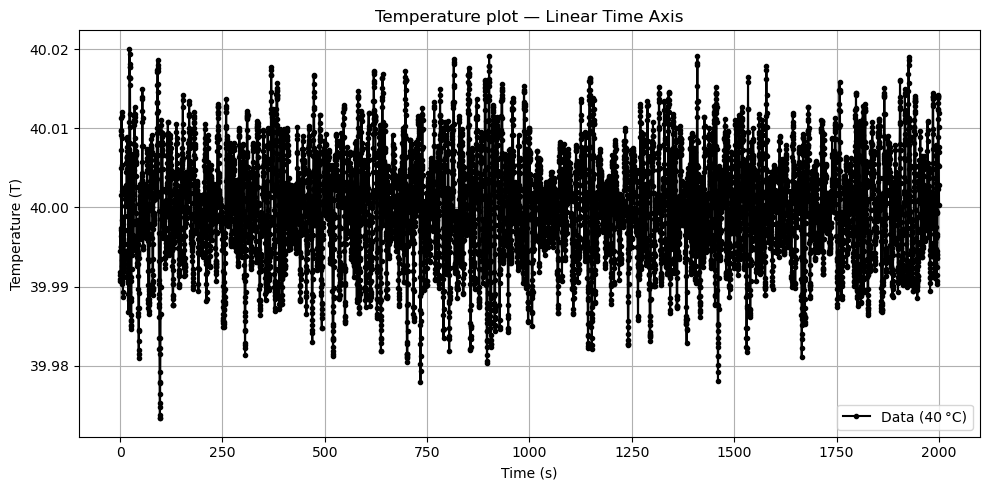

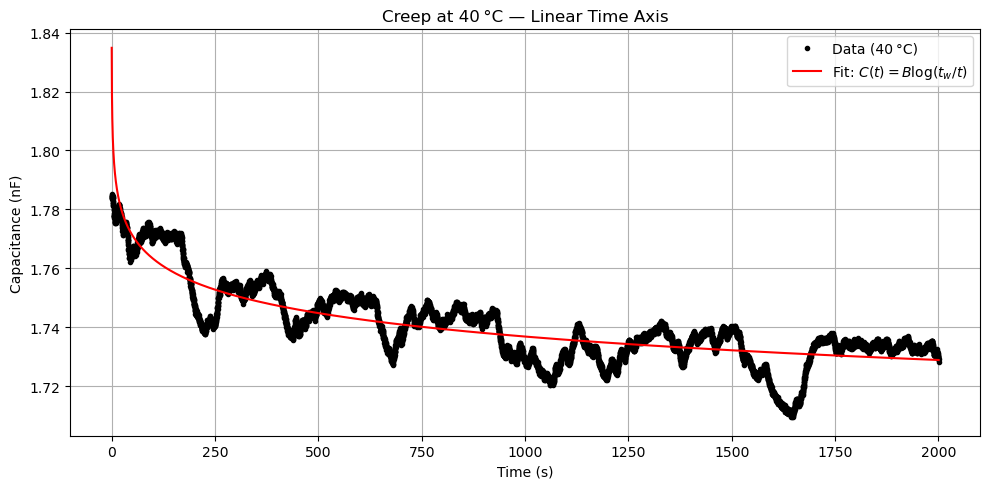

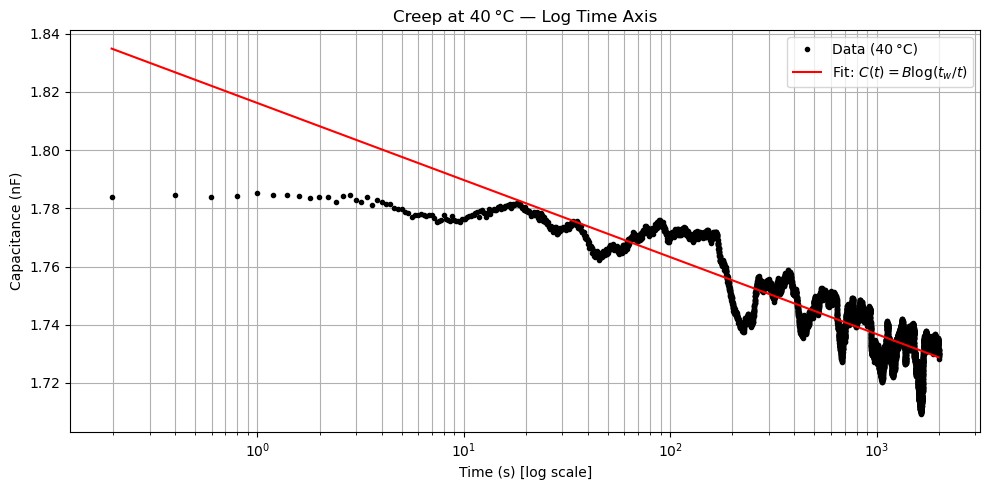


--- Log Creep Fit at 40 °C ---
Fit time range: 0.20 s to 2000.41 s
B   = 1.1489e-02 ± 7.1943e-05 nF
tw  = 449157148733439122089381200883360362346620979823227616850851498295296.00 ± 426005162101886058956836734239126843330619864204396987825310320820224.00 s


In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

# --- CONFIGURATION ---
filename = "Data/40_40T_1dT_10000N.lvm"
delimiter = '\t'

# --- MODEL: Logarithmic Creep ---
# Redefine the model without using np.errstate to test robustness
def log_creep(t, B, tw):
    output = np.full_like(t, np.nan)
    valid = (t > 0) & (t < tw)
    output[valid] = B * np.log(tw / t[valid])
    return output

# --- LOAD DATA ---
data = np.loadtxt(filename, delimiter=delimiter)
t = data[:, 0]           # Time (s)
temp = data[:,1]
C_nF = data[:, 2]        # Capacitance (nF)
C = C_nF * 1e-9          # Convert to Farads

mask2 = (t<2010)
t = t[mask2]
temp = temp[mask2]
C_nF = C_nF[mask2]
C = C[mask2]

# --- FIT RANGE MASK ---
t_max = np.max(t)
tw_guess = t_max + 50
B_guess = 1.1489e-02

mask = (t > 0) & (t < tw_guess) 
t_fit = t[mask]
C_fit = C[mask]

# --- CURVE FIT ---
popt, pcov = curve_fit(log_creep, t_fit, C_fit, p0=[B_guess, tw_guess,],maxfev=10000)
B_fit, tw_fit = popt
B_err, tw_err = np.sqrt(np.diag(pcov))
C_model = log_creep(t, B_fit, tw_fit)


# --- PLOT: LINEAR TIME AXIS ---
plt.figure(figsize=(10, 5))
plt.plot(t, temp, 'k.-', label='Data (40 °C)')

plt.xlabel("Time (s)")
plt.ylabel("Temperature (T)")
#plt.xlim(2000,2050)
plt.title("Temperature plot — Linear Time Axis")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()



# --- PLOT: LINEAR TIME AXIS ---
plt.figure(figsize=(10, 5))
plt.plot(t, C_nF, 'k.', label='Data (40 °C)')
plt.plot(t, C_model * 1e9, 'r-', label='Fit: $C(t) = B \\log(t_w / t)$')
plt.xlabel("Time (s)")
plt.ylabel("Capacitance (nF)")
#plt.xlim(2000,2050)
plt.title("Creep at 40 °C — Linear Time Axis")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# --- PLOT: LOG TIME AXIS ---
plt.figure(figsize=(10, 5))
plt.semilogx(t, C_nF, 'k.', label='Data (40 °C)')
plt.semilogx(t, C_model * 1e9, 'r-', label='Fit: $C(t) = B \\log(t_w / t)$')
plt.xlabel("Time (s) [log scale]")
plt.ylabel("Capacitance (nF)")
plt.title("Creep at 40 °C — Log Time Axis")
plt.grid(True, which='both')
plt.legend()
plt.tight_layout()
plt.show()

# --- PRINT RESULTS ---
print("\n--- Log Creep Fit at 40 °C ---")
print(f"Fit time range: {t_fit[0]:.2f} s to {t_fit[-1]:.2f} s")
print(f"B   = {B_fit*1e9:.4e} ± {B_err*1e9:.4e} nF")
print(f"tw  = {tw_fit:.2f} ± {tw_err:.2f} s")


## Trying a new Model

Time range: 0.196608 2000.410509
Capacitance range (nF): 1.709388 1.785108


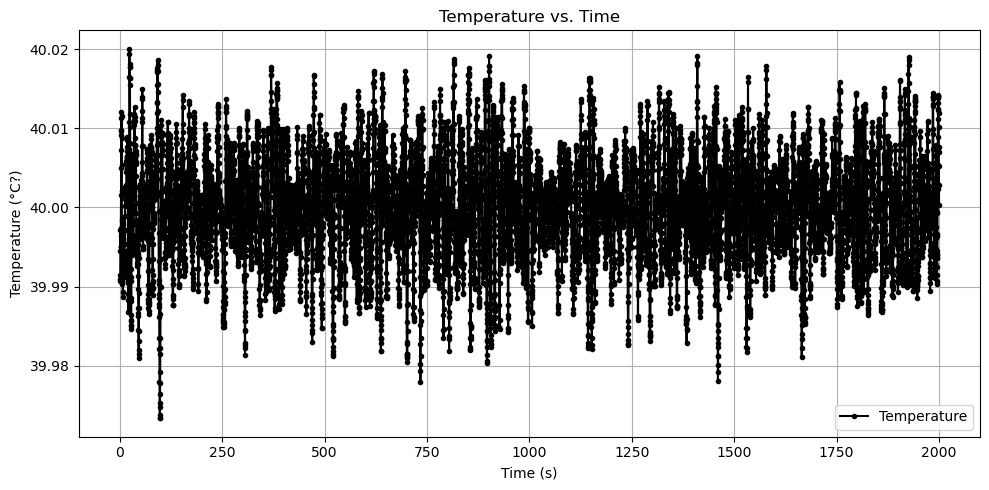

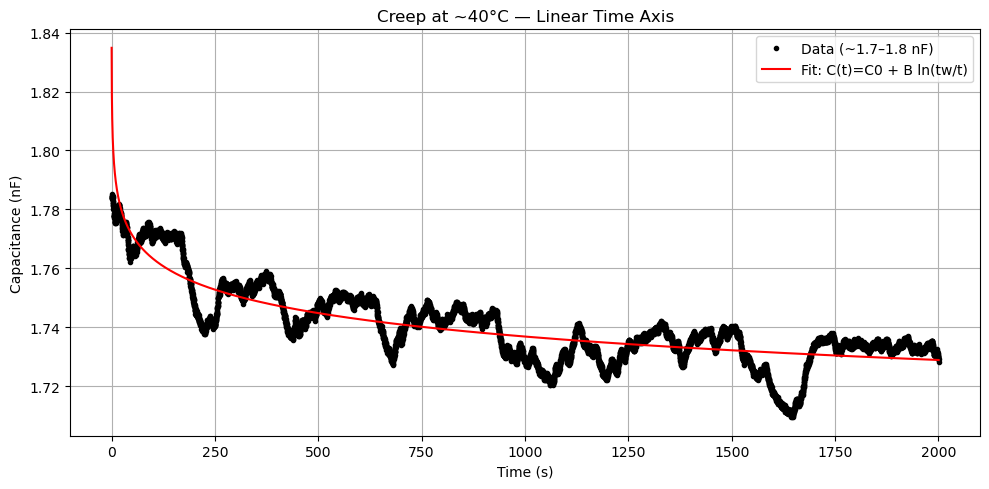

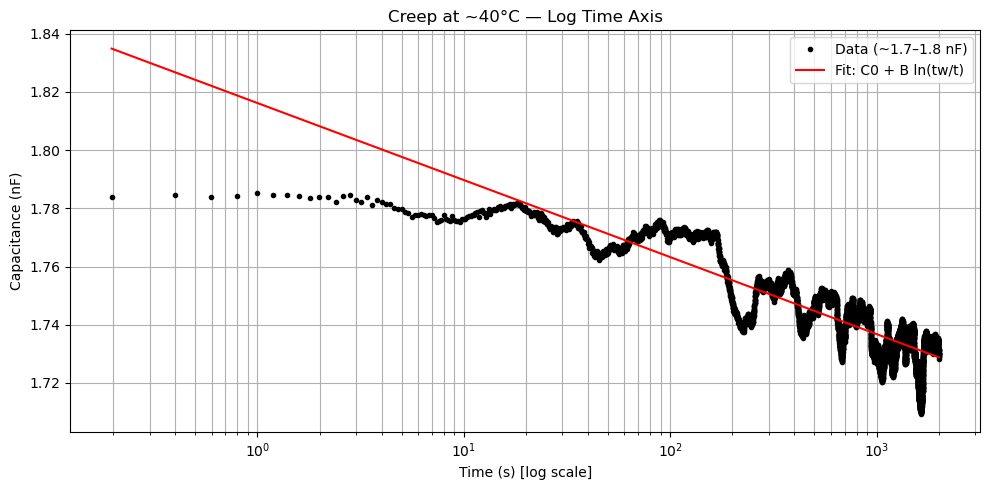


--- Log Creep + Offset Fit ---
Fitting range: t=0.20 to 2000.41 s
B     = 0.01149 ± 0.00007 nF
tw    = 2524.21 ± 0.00 s
C0    = 1.72615 ± 0.00011 nF


In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

# ---------------------------
# 1)  MODEL in nF units
# ---------------------------
def log_creep_offset_nF(t, B, tw, C0):
    """
    Returns: C(t) in nF = C0 + B * ln(tw / t).
    Valid only for times 0 < t < tw. Outside that, returns NaN.
    
    Parameters:
      t    : time array in seconds
      B    : amplitude for the log term (in nF)
      tw   : characteristic time (in seconds)
      C0   : offset in nF
    """
    out = np.full_like(t, np.nan, dtype=float)
    valid = (t > 0) & (t < tw)
    out[valid] = C0 + B * np.log(tw / t[valid])
    return out

# ---------------------------
# 2)  LOAD DATA
# ---------------------------
filename = "Data/40_40T_1dT_10000N.lvm"
delimiter = '\t'

data = np.loadtxt(filename, delimiter=delimiter)
t_all     = data[:, 0]   # time (s)
temp_all  = data[:, 1]   # temperature (°C or K, whichever your file uses)
C_nF_all  = data[:, 2]   # capacitance in nF (per your statement)

# If there's a noisy zero at t=0, or if you only want up to ~2000 s:
mask = (t_all > 0) & (t_all < 2001)
t   = t_all[mask]
temp= temp_all[mask]
C_nF= C_nF_all[mask]

print("Time range:", t.min(), t.max())
print("Capacitance range (nF):", C_nF.min(), C_nF.max())

# ---------------------------
# 3)  INITIAL GUESSES
# ---------------------------
# From your prints, the data is around 1.71 to 1.79 nF. 
# The log variation is only ~0.07 nF total, so let's guess:
B_guess  = 0.01      # nF amplitude for the log
tw_guess = 3000.0    # s, a bit above max(t)
C0_guess = 1.75      # nF, near the middle of your observed data

p0 = [B_guess, tw_guess, C0_guess]

# ---------------------------
# 4)  BOUNDS (optional)
# ---------------------------
# If you want to keep them unbounded, set bounds=(-np.inf, np.inf).
# Here, let's allow only positive B and tw, and limit C0 near your data:
lower_bounds = [0.0,    0.0,    1.6]
upper_bounds = [0.1, 1.0e5,    2.0]  
# Explanation:
#  - B from 0 to 0.1 nF
#  - tw from 0 to 1e5 s
#  - C0 from 1.6 to 2.0 nF

# ---------------------------
# 5)  FIT
# ---------------------------
t_fit = t  # If you only want to fit a sub-range, apply a narrower mask
C_fit = C_nF

popt, pcov = curve_fit(
    log_creep_offset_nF,
    t_fit,
    C_fit,
    p0=p0,
    bounds=(lower_bounds, upper_bounds),
    maxfev=10000
)
B_fit, tw_fit, C0_fit = popt
B_err, tw_err, C0_err = np.sqrt(np.diag(pcov))

# Evaluate model for plotting
C_model = log_creep_offset_nF(t, B_fit, tw_fit, C0_fit)

# ---------------------------
# 6)  PLOTTING
# ---------------------------
# Plot #1: Temperature
plt.figure(figsize=(10, 5))
plt.plot(t, temp, 'k.-', label='Temperature')
plt.xlabel("Time (s)")
plt.ylabel("Temperature (°C?)")
plt.title("Temperature vs. Time")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# Plot #2: Creep (linear axis)
plt.figure(figsize=(10, 5))
plt.plot(t, C_nF, 'k.', label='Data (~1.7–1.8 nF)')
plt.plot(t, C_model, 'r-', label='Fit: C(t)=C0 + B ln(tw/t)')
plt.xlabel("Time (s)")
plt.ylabel("Capacitance (nF)")
plt.title("Creep at ~40°C — Linear Time Axis")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# Plot #3: Creep (log axis)
plt.figure(figsize=(10, 5))
plt.semilogx(t, C_nF, 'k.', label='Data (~1.7–1.8 nF)')
plt.semilogx(t, C_model, 'r-', label='Fit: C0 + B ln(tw/t)')
plt.xlabel("Time (s) [log scale]")
plt.ylabel("Capacitance (nF)")
plt.title("Creep at ~40°C — Log Time Axis")
plt.grid(True, which='both')
plt.legend()
plt.tight_layout()
plt.show()

# ---------------------------
# 7)  PRINT FIT RESULTS
# ---------------------------
print("\n--- Log Creep + Offset Fit ---")
print(f"Fitting range: t={t_fit[0]:.2f} to {t_fit[-1]:.2f} s")
print(f"B     = {B_fit:.5f} ± {B_err:.5f} nF")
print(f"tw    = {tw_fit:.2f} ± {tw_err:.2f} s")
print(f"C0    = {C0_fit:.5f} ± {C0_err:.5f} nF")


In [3]:
print("Cap (nF) min:", np.min(C_nF), " max:", np.max(C_nF))
print("Time range:", t.min(), t.max())
print("Capacitance range (nF):", C_nF.min(), C_nF.max())

Cap (nF) min: 1.709388  max: 1.785108
Time range: 0.196608 2000.410509
Capacitance range (nF): 1.709388 1.785108


## Understanding Capacitance Dips

Time range: 0.196608 2000.410509
Capacitance range (nF): 1.709388 1.785108


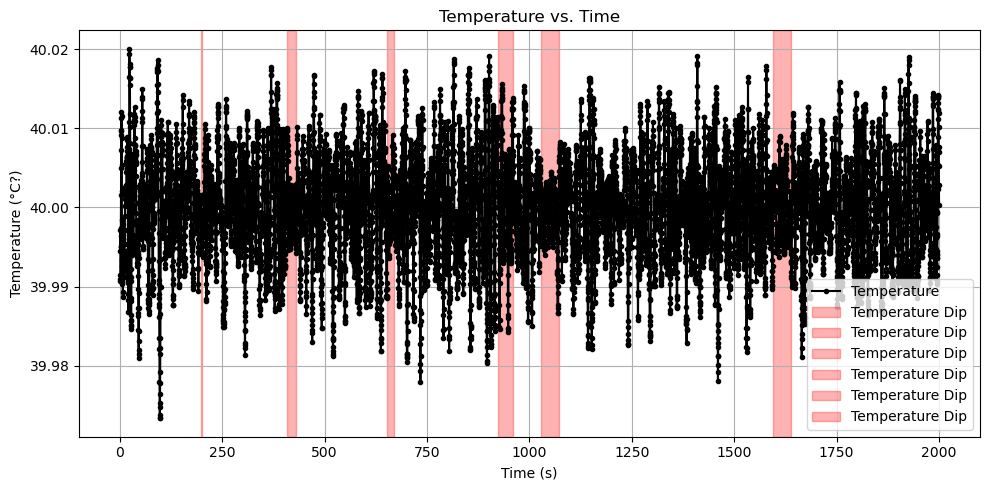

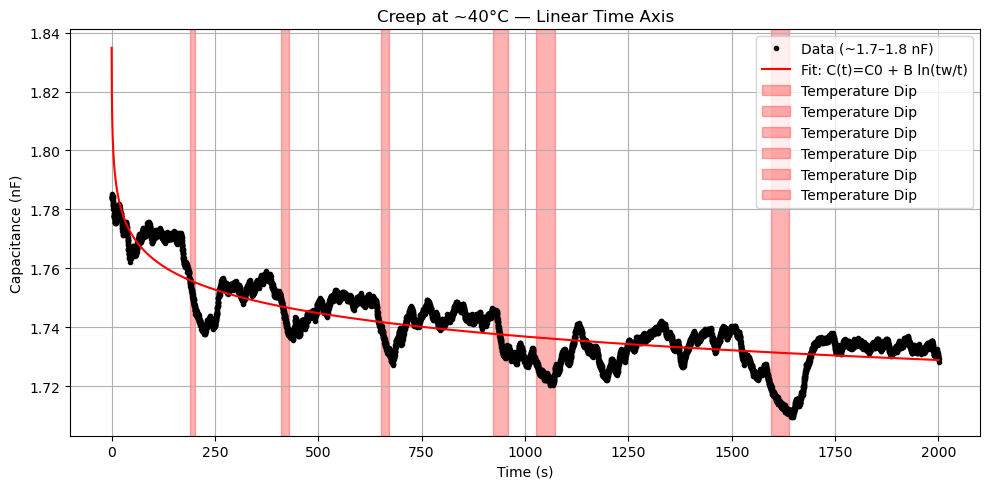

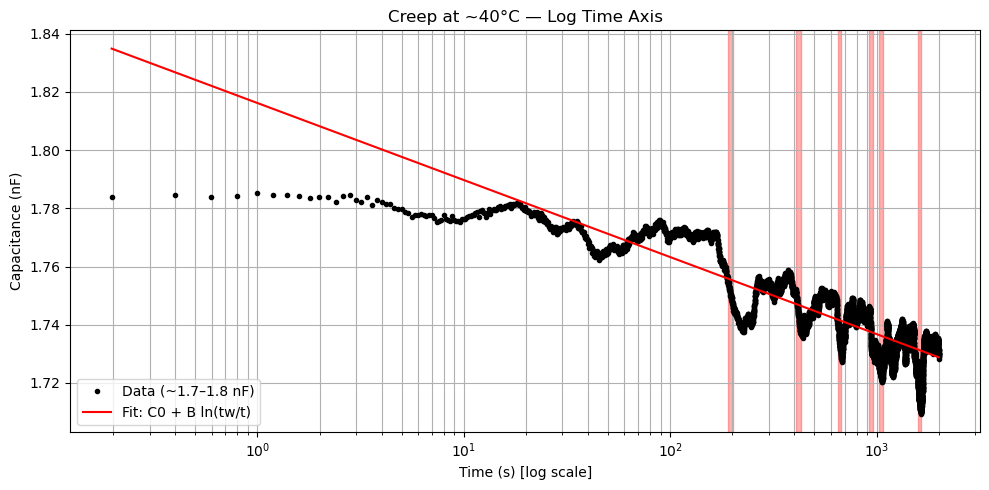


--- Log Creep + Offset Fit ---
Fitting range: t=0.20 to 2000.41 s
B     = 0.01149 ± 0.00007 nF
tw    = 2524.21 ± 0.00 s
C0    = 1.72615 ± 0.00011 nF


In [4]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

#%matplotlib widget
# ---------------------------
# 1)  MODEL in nF units
# ---------------------------
def log_creep_offset_nF(t, B, tw, C0):
    """
    Returns: C(t) in nF = C0 + B * ln(tw / t).
    Valid only for times 0 < t < tw. Outside that, returns NaN.
    
    Parameters:
      t    : time array in seconds
      B    : amplitude for the log term (in nF)
      tw   : characteristic time (in seconds)
      C0   : offset in nF
    """
    out = np.full_like(t, np.nan, dtype=float)
    valid = (t > 0) & (t < tw)
    out[valid] = C0 + B * np.log(tw / t[valid])
    return out

# ---------------------------
# 2)  LOAD DATA
# ---------------------------
filename = "Data/40_40T_1dT_10000N.lvm"
delimiter = '\t'

data = np.loadtxt(filename, delimiter=delimiter)
t_all     = data[:, 0]   # time (s)
temp_all  = data[:, 1]   # temperature (°C or K, whichever your file uses)
C_nF_all  = data[:, 2]   # capacitance in nF (per your statement)

# If there's a noisy zero at t=0, or if you only want up to ~2000 s:
mask = (t_all > 0) & (t_all < 2001)
t   = t_all[mask]
temp= temp_all[mask]
C_nF= C_nF_all[mask]

print("Time range:", t.min(), t.max())
print("Capacitance range (nF):", C_nF.min(), C_nF.max())

# ---------------------------
# 3)  INITIAL GUESSES
# ---------------------------
# From your prints, the data is around 1.71 to 1.79 nF. 
# The log variation is only ~0.07 nF total, so let's guess:
B_guess  = 0.01      # nF amplitude for the log
tw_guess = 3000.0    # s, a bit above max(t)
C0_guess = 1.75      # nF, near the middle of your observed data

p0 = [B_guess, tw_guess, C0_guess]

# ---------------------------
# 4)  BOUNDS (optional)
# ---------------------------
# If you want to keep them unbounded, set bounds=(-np.inf, np.inf).
# Here, let's allow only positive B and tw, and limit C0 near your data:
lower_bounds = [0.0,    0.0,    1.6]
upper_bounds = [0.1, 1.0e5,    2.0]  
# Explanation:
#  - B from 0 to 0.1 nF
#  - tw from 0 to 1e5 s
#  - C0 from 1.6 to 2.0 nF

# ---------------------------
# 5)  FIT
# ---------------------------
t_fit = t  # If you only want to fit a sub-range, apply a narrower mask
C_fit = C_nF

popt, pcov = curve_fit(
    log_creep_offset_nF,
    t_fit,
    C_fit,
    p0=p0,
    bounds=(lower_bounds, upper_bounds),
    maxfev=10000
)
B_fit, tw_fit, C0_fit = popt
B_err, tw_err, C0_err = np.sqrt(np.diag(pcov))

# Evaluate model for plotting
C_model = log_creep_offset_nF(t, B_fit, tw_fit, C0_fit)

# ---------------------------
# 6)  PLOTTING
# ---------------------------
# Plot #1: Temperature
plt.figure(figsize=(10, 5))
plt.plot(t, temp, 'k.-', label='Temperature')
plt.xlabel("Time (s)")
plt.ylabel("Temperature (°C?)")
plt.axvspan(197, 201, color='r', alpha=0.3, label="Temperature Dip")
plt.axvspan(409, 429, color='r', alpha=0.3, label="Temperature Dip")
plt.axvspan(651, 670, color='r', alpha=0.3, label="Temperature Dip")
plt.axvspan(923, 960, color='r', alpha=0.3, label="Temperature Dip")
plt.axvspan(1027, 1073, color='r', alpha=0.3, label="Temperature Dip")
plt.axvspan(1596, 1638, color='r', alpha=0.3, label="Temperature Dip")


plt.title("Temperature vs. Time")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# Plot #2: Creep (linear axis)
plt.figure(figsize=(10, 5))
plt.plot(t, C_nF, 'k.', label='Data (~1.7–1.8 nF)')
plt.plot(t, C_model, 'r-', label='Fit: C(t)=C0 + B ln(tw/t)')
plt.xlabel("Time (s)")
plt.ylabel("Capacitance (nF)")
plt.title("Creep at ~40°C — Linear Time Axis")
plt.axvspan(190, 201, color='r', alpha=0.3, label="Temperature Dip")
plt.axvspan(409, 429, color='r', alpha=0.3, label="Temperature Dip")
plt.axvspan(651, 670, color='r', alpha=0.3, label="Temperature Dip")
plt.axvspan(923, 960, color='r', alpha=0.3, label="Temperature Dip")
plt.axvspan(1027, 1073, color='r', alpha=0.3, label="Temperature Dip")
plt.axvspan(1596, 1638, color='r', alpha=0.3, label="Temperature Dip")

plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# Plot #3: Creep (log axis)
plt.figure(figsize=(10, 5))
plt.semilogx(t, C_nF, 'k.', label='Data (~1.7–1.8 nF)')
plt.semilogx(t, C_model, 'r-', label='Fit: C0 + B ln(tw/t)')
plt.xlabel("Time (s) [log scale]")
plt.ylabel("Capacitance (nF)")
plt.title("Creep at ~40°C — Log Time Axis")
plt.axvspan(190, 201, color='r', alpha=0.3)
plt.axvspan(409, 429, color='r', alpha=0.3)
plt.axvspan(651, 670, color='r', alpha=0.3)
plt.axvspan(923, 960, color='r', alpha=0.3)
plt.axvspan(1027, 1073, color='r', alpha=0.3)
plt.axvspan(1596, 1638, color='r', alpha=0.3)

plt.grid(True, which='both')
plt.legend()
plt.tight_layout()
plt.show()

# ---------------------------
# 7)  PRINT FIT RESULTS
# ---------------------------
print("\n--- Log Creep + Offset Fit ---")
print(f"Fitting range: t={t_fit[0]:.2f} to {t_fit[-1]:.2f} s")
print(f"B     = {B_fit:.5f} ± {B_err:.5f} nF")
print(f"tw    = {tw_fit:.2f} ± {tw_err:.2f} s")
print(f"C0    = {C0_fit:.5f} ± {C0_err:.5f} nF")
